# Pretty Example
Make a pretty example case and a movie for the group website.

In [15]:
#import matplotlib
#matplotlib.use('Qt5Agg')

import subprocess
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.sun import constants
from sunpy.net import Fido,attrs
from sunpy.time import TimeRange
import yt
from astropy.utils.console import ProgressBar
import dask.distributed

import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.interfaces import EbtelInterface, UniformHeating
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

In [29]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:33562 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


## Magnetogram and 3D Field
First grab a recent magnetogram with FIDO. Specifically, we're looking for AR 12699.

In [ ]:
result_hmi = Fido.search(
    attrs.Time(TimeRange('2017/12/25 22:57:00',1*u.min)),
    attrs.Instrument('HMI') & attrs.vso.Physobs('LOS_magnetic_field'),)

In [2]:
#hmi_files = Fido.fetch(result_hmi)
hmi_files = '/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2017_12_25_22_58_30_tai_magnetogram.fits'

In [3]:
hmi = sunpy.map.Map(hmi_files).rotate()

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [4]:
cx,cy = 340*u.arcsec,340*u.arcsec
wx,wy = 350*u.arcsec,350*u.arcsec
lc = SkyCoord(cx - wx/2,cy - wy/2,frame=hmi.coordinate_frame)
rc = SkyCoord(cx + wx/2,cy + wy/2,frame=hmi.coordinate_frame)
hmi_zoom = hmi.submap(lc,rc).resample([125, 125]*u.pixel)

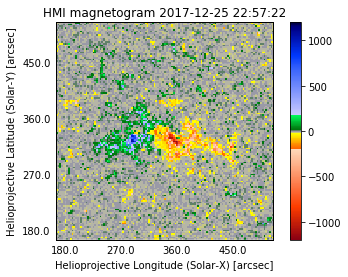

In [5]:
fig = plt.figure()
ax = fig.gca(projection=hmi_zoom)
hmi_zoom.plot(cmap='hmimag',vmin=-1.2e3,vmax=1.2e3,axes=ax)
plt.colorbar()

Now, extrapolate a 3D vector magnetic field from the lower boundary.

In [6]:
extrapolator = synthesizAR.extrapolate.ObliqueSchmidt(hmi_zoom, 0.35*constants.radius, 125*u.pixel)

In [7]:
B_field = extrapolator.extrapolate()

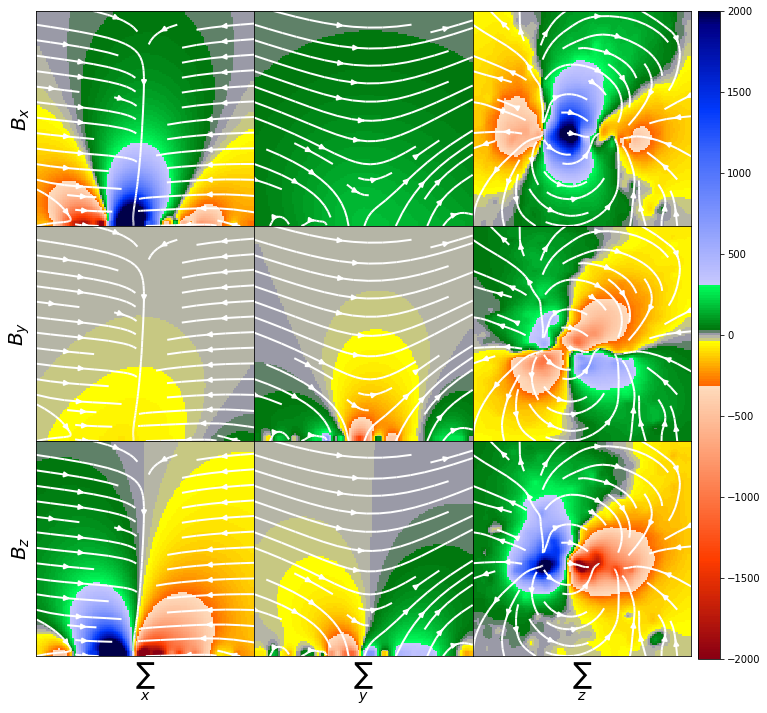

In [8]:
synthesizAR.extrapolate.peek_projections(B_field)

In [9]:
fieldlines = extrapolator.trace_fieldlines(B_field,1000,loop_length_range=[2e9,1e11]*u.cm,mask_threshold=0.1)

yt : [INFO     ] 2018-02-10 23:55:37,473 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-10 23:55:37,473 Parameters: domain_dimensions         = [125 125 125]
yt : [INFO     ] 2018-02-10 23:55:37,474 Parameters: domain_left_edge          = [ -1.39594231e+10  -1.25295905e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-10 23:55:37,474 Parameters: domain_right_edge         = [  1.66402616e+10   1.49358670e+10   2.43427800e+10]
yt : [INFO     ] 2018-02-10 23:55:37,475 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-02-10 23:55:38,338 AMRKDTree rebuilt, Final Volume: 2.045851e+31
Streamlining: 100%|██████████| 1000/1000 [00:01<00:00, 541.88it/s]
yt : [INFO     ] 2018-02-10 23:55:41,530 AMRKDTree rebuilt, Final Volume: 2.045851e+31
Streamlining: 100%|██████████| 283/283 [00:00<00:00, 598.25it/s]
yt : [INFO     ] 2018-02-10 23:55:42,695 AMRKDTree rebuilt, Final Volume: 2.045851e+31
Streamlining: 100%|██████████| 90/90 [00:00<00:00, 510.81it/s]
yt : [INFO 

FloatProgress(value=0.0)

In [ ]:
extrapolator.peek(fieldlines, line_frequency=5)

## Field and Loops

In [10]:
active_region = synthesizAR.Field(hmi_zoom, fieldlines=fieldlines)

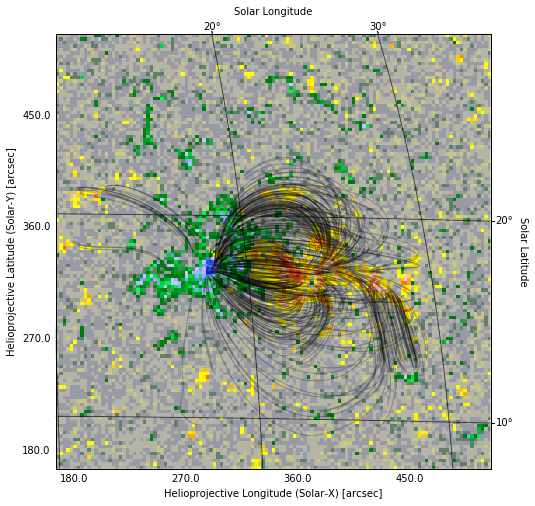

In [12]:
active_region.peek(line_frequency=2,alpha=0.25)

Text(0.5,0,'$2L$ [Mm]')

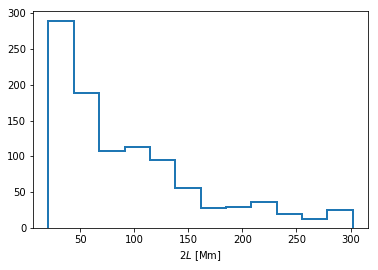

In [13]:
plt.hist([l.full_length.to(u.Mm).value for l in active_region.loops],histtype='step',lw=2,bins='scott');
plt.xlabel(r'$2L$ [Mm]')

## Loop Hydrodynamics
Next, we'll run an EBTEL simulation for each of our traced fieldlines. 

In [ ]:
class RandomNanoflares(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        
    def calculate_event_properties(self,loop):
        self.number_events = 1
        start_time = np.random.uniform(low=0,high=self.base_config['total_time'])
        max_energy = (self.heating_options['stress_level']*loop.field_strength.mean().value)**2/(8.*np.pi)
        return {'magnitude':[max_energy/(self.heating_options['duration']/2.)],
                'rise_start':[start_time],
                'rise_end':[start_time+self.heating_options['duration']/2],
                'decay_start':[start_time+self.heating_options['duration']/2],
                'decay_end':[start_time+self.heating_options['duration']]}

In [ ]:
heating_options = {
    'duration':200.0,
    'stress_level':0.3,
}
heating_model = RandomNanoflares(heating_options)

In [16]:
heating_options = {
    'duration':200,
    'average_waiting_time':4800,
    'duration_rise':100,
    'duration_decay':100,
    'stress_level':0.3
}
heating_model = UniformHeating(heating_options)

In [17]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 100.0

In [18]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/pretty_example/hydro_config/',
                                 '/storage-home/w/wtb2/data/pretty_example/hydro_results/')

In [19]:
active_region.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

In [20]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [21]:
for loop in active_region.loops:
    ebtel_runner(loop)

In [22]:
active_region.load_loop_simulations(ebtel_interface,
                                    savefile='/storage-home/w/wtb2/data/pretty_example/loop_parameters.h5')

FloatProgress(value=0.0)

Text(0.5,0,'$t$ [s]')

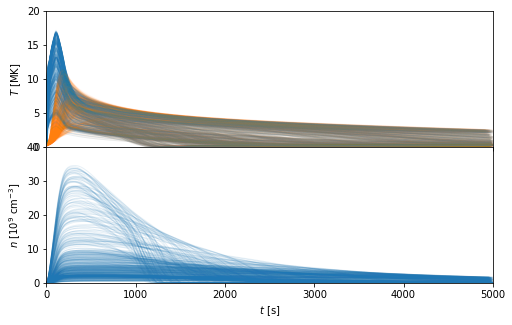

In [23]:
fig,axes = plt.subplots(2,1,figsize=(8,5),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in active_region.loops[::2]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.1,lw=1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C1',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1,lw=1)
    
axes[0].set_xlim([0,5000])
axes[0].set_ylim([0,20])
axes[1].set_ylim([0,40])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

Save the active region 

In [24]:
active_region.save(savedir='/storage-home/w/wtb2/data/pretty_example/field_checkpoint')

Reload it as needed

In [ ]:
active_region = synthesizAR.Field.restore('/storage-home/w/wtb2/data/pretty_example/field_checkpoint/')

## Computing Emission
This part is a bit more tricky. We need to construct a new instrument and observer for each timestep and adjust the observing coordinate as some function of time. It will be easiest to keep latitude as a constant and adjust longitude as a function of time, from $\Phi_a$ to $\Phi_b$.

It is also best to choose an interval near the middle of our simulation interval so that we capture as many filled loops as possible.

First flatten all counts and interpolate loops to HEEQ coordinates.

In [30]:
aia = InstrumentSDOAIA([0,5000 + 10] * u.s)
observer = synthesizAR.Observer(active_region,[aia],parallel=True)
observer.build_detector_files('/storage-home/w/wtb2/data/pretty_example/', ds=0.6 * u.arcsec)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [31]:
tasks = observer.flatten_detector_counts()

In [32]:
tasks['SDO_AIA_counts'].compute()

In [33]:
observer.parallel = False

Now bin the detector counts, changing the observing coordinate at each timestep.

In [35]:
hgs_center = active_region.magnetogram.center.transform_to('heliographic_stonyhurst')

In [36]:
dt = 10
observing_time = np.arange(0,5000 + dt,dt) * u.s

In [37]:
start_lon = hgs_center.lon - 90 * u.deg
stop_lon = hgs_center.lat + 90 * u.deg
observing_longitude = start_lon + ((stop_lon - start_lon)
                                   /(observing_time[-1] - observing_time[0]) * (observing_time - observing_time[0]))

In [39]:
with ProgressBar(len(observing_time) - 1, ipython_widget=True,) as progress:
    for t_obs,lon_obs in zip(observing_time, observing_longitude):
        observer_coord = SkyCoord(lon=lon_obs,
                                  lat=active_region.magnetogram.observer_coordinate.lat,
                                  radius=active_region.magnetogram.observer_coordinate.radius,
                                  frame='heliographic_stonyhurst')
        observer.instruments[0].observing_time = u.Quantity([t_obs])
        observer.instruments[0].observer_coordinate = observer_coord
        observer.instruments[0].make_detector_array(observer.field)
        observer.bin_detector_counts('/storage-home/w/wtb2/data/pretty_example/')
        progress.update()

FloatProgress(value=0.0)

## Visualization

In [118]:
wx = 450 * u.arcsec
wy = 450 * u.arcsec
norm = matplotlib.colors.SymLogNorm(1e-6,vmin=1,vmax=2e3)
channel_1 = '171'
channel_2 = '211'

In [119]:
fig = plt.figure(figsize=(8,8))
with ProgressBar(observing_time.shape[0], ipython_widget=True) as progress:
    for i in range(observing_time.shape[0]):
        # Create maps with masks
        m_1 = sunpy.map.Map(f'/storage-home/w/wtb2/data/pretty_example/SDO_AIA/{channel_1}/map_t{i:06d}.fits')
        mask = np.ma.masked_less_equal(m_1.data,1e-2)
        m_1 = sunpy.map.Map(m_1.data, m_1.meta, mask=mask.mask)
        m_2 = sunpy.map.Map(f'/storage-home/w/wtb2/data/pretty_example/SDO_AIA/{channel_2}/map_t{i:06d}.fits')
        mask = np.ma.masked_less_equal(m_2.data,1e-2)
        m_2 = sunpy.map.Map(m_2.data, m_2.meta, mask=mask.mask)
        # Create axis
        ax = fig.gca(projection=m_1)
        ax.set_facecolor('k')
        # Add plot(s)
        im_1 = m_1.plot(axes=ax,annotate=False,title=False,norm=norm)
        im_1.set_alpha(1)
        im_2 = m_2.plot(axes=ax,annotate=False,title=False,norm=norm)
        im_2.set_alpha(0.75)
        # Add HGS grid
        ax.grid(alpha=0)
        hgs_grid = m_1.draw_grid(grid_spacing=10*u.deg,color='w',alpha=0.5)
        # Make sure view is fixed
        lc = SkyCoord(m_1.center.Tx-wx/2,m_1.center.Ty-wy/2,frame=m_1.coordinate_frame)
        rc = SkyCoord(m_1.center.Tx+wx/2,m_1.center.Ty+wy/2,frame=m_1.coordinate_frame)
        ax.plot_coord(lc,'k.')
        ax.plot_coord(rc,'k.')
        # Remove a bunch of labels and ticks
        ax.coords[0].set_ticks_visible(False)
        ax.coords[1].set_ticks_visible(False)
        ax.coords[0].set_ticklabel_visible(False)
        ax.coords[1].set_ticklabel_visible(False)
        hgs_grid[0].set_ticklabel_visible(False)
        hgs_grid[1].set_ticklabel_visible(False)
        hgs_grid[0].set_axislabel('')
        hgs_grid[1].set_axislabel('')
        fig.savefig(f'/storage-home/w/wtb2/data/pretty_example/figs/SDO_AIA_{channel_1}_{channel_2}_t{i:06d}.pdf',)
        fig.clf()
        progress.update()

FloatProgress(value=0.0)

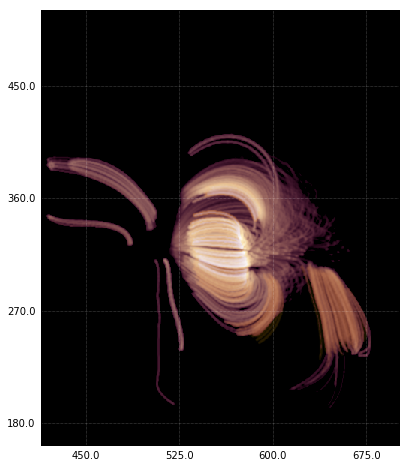

In [117]:
norm = matplotlib.colors.SymLogNorm(1e-6,vmin=1,vmax=2e3)
fig = plt.figure(figsize=(8,8))
m1 = sunpy.map.Map('/storage-home/w/wtb2/data/pretty_example/SDO_AIA/171/map_t000150.fits')
mask = np.ma.masked_less_equal(m1.data,1e-2)
m1 = sunpy.map.Map(m1.data,m1.meta,mask=mask.mask)
m2 = sunpy.map.Map('/storage-home/w/wtb2/data/pretty_example/SDO_AIA/211/map_t000150.fits')
mask = np.ma.masked_less_equal(m2.data,1e-2)
m2 = sunpy.map.Map(m2.data,m2.meta,mask=mask.mask)
ax = fig.gca(projection=m1)
ax.set_facecolor('k')
im = m1.plot(axes=ax,title=False,annotate=False,norm=norm)
im.set_alpha(1)
im = m2.plot(axes=ax,title=False,annotate=False,norm=norm)
im.set_alpha(0.75)